# Project 4: West Nile Virus Classification
---
    Chenyze | Elaine | Kenrick | Raphael
    
---
Project notebook organisation:<br>
[1 - Exploratory Data Analysis and Feature Engineering](./1_eda_and_feature_engineering.ipynb)<br>
**2 - Model Tuning and Insights** (current notebook)<br>
<br>
<br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-4:-West-Nile-Virus-Classification" data-toc-modified-id="Project-4:-West-Nile-Virus-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project 4: West Nile Virus Classification</a></span></li><li><span><a href="#Preparing-Data" data-toc-modified-id="Preparing-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparing Data</a></span><ul class="toc-item"><li><span><a href="#Cleaning-up-data" data-toc-modified-id="Cleaning-up-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Cleaning up data</a></span></li><li><span><a href="#Populating-dictionary-of-variables" data-toc-modified-id="Populating-dictionary-of-variables-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Populating dictionary of variables</a></span></li></ul></li><li><span><a href="#Functions-and-Dictionaries-for-modelling" data-toc-modified-id="Functions-and-Dictionaries-for-modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functions and Dictionaries for modelling</a></span></li><li><span><a href="#Baseline-models-with-no-parameter-tuning" data-toc-modified-id="Baseline-models-with-no-parameter-tuning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Baseline models with no parameter-tuning</a></span></li><li><span><a href="#GridSearching-for-parameter-tuning" data-toc-modified-id="GridSearching-for-parameter-tuning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>GridSearching for parameter tuning</a></span></li><li><span><a href="#Evaluating-our-models" data-toc-modified-id="Evaluating-our-models-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluating our models</a></span></li><li><span><a href="#Cost-Benefit-Analysis" data-toc-modified-id="Cost-Benefit-Analysis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Cost-Benefit Analysis</a></span><ul class="toc-item"><li><span><a href="#Cost" data-toc-modified-id="Cost-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Cost</a></span></li><li><span><a href="#Benefit" data-toc-modified-id="Benefit-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Benefit</a></span></li><li><span><a href="#Effectiveness-of-spraying-efforts-thus-far" data-toc-modified-id="Effectiveness-of-spraying-efforts-thus-far-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Effectiveness of spraying efforts thus far</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Conclusion-and-Recommendations" data-toc-modified-id="Conclusion-and-Recommendations-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion and Recommendations</a></span></li></ul></div>

In [1]:
# importing essential libraries for data cleaning and EDA
import numpy as np
import pandas as pd

# for handling date time
import datetime as dt

# stats and other libraries
import scipy.stats as stats

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

# for handling geographic data

# modeling libraries
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_auc_score


import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import scipy.stats as stats
import string
import warnings
warnings.filterwarnings('ignore')

import featuretools as ft
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE



sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline


Using TensorFlow backend.


# Preparing Data

In [4]:
# reading pickle of processed data sets from 1_combined_eda

df_processed = pd.read_pickle('../assets/processed.zip')
df_dict = df_processed.to_dict()


## Cleaning up data

In [5]:
# dropping dummy variable of UNSPECIFIED CULEX from both data sets as we will be using it as the control set
# dropping WnvPresent for test data set (this was added in when we processed train and test set, as we
# aligned it to ensure that train and test sets have the same columns for other dummy variables)


for i in df_dict.keys():
    df_dict[i]['train'] = df_dict[i]['train'].drop(columns = 'Species_UNSPECIFIED CULEX')
    df_dict[i]['test'] = df_dict[i]['test'].drop(columns = ['Species_UNSPECIFIED CULEX', 'WnvPresent'])

## Populating dictionary of variables

In [6]:
# defining empty dictionaries to hold validation sets

X_train = {}
X_test = {}
y_train = {}
y_test = {}
X_all = {}
y_all = {}
test_all = {}

In [7]:
# for loop to populate dictionaries of X and Y training and test sets

for i in df_dict.keys():
    X_train[i], X_test[i], y_train[i], y_test[i] = \
    train_test_split(df_dict[i]['train'].drop(columns = 'WnvPresent'), df_dict[i]['train']['WnvPresent'], \
                     test_size = 0.25, stratify = df_dict[i]['train']['WnvPresent'], random_state = 42)
    X_all[i] = df_dict[i]['train'].drop(columns = 'WnvPresent')
    y_all[i] = df_dict[i]['train']['WnvPresent']
    test_all[i] = df_dict[i]['test']



# Functions and Dictionaries for modelling

In [8]:
# Defining dictionary of pipeline transformers and classifiers

pipe_dict = {'ss' : ('ss', StandardScaler()),
             'lr' : ('lr', LogisticRegression()),
             'knn' : ('knn', KNeighborsClassifier()),
             'dt' : ('dt', DecisionTreeClassifier()),
             'rf' : ('rf', RandomForestClassifier()),
             'et' : ('et', ExtraTreesClassifier()),
             'xgc' : ('xgc', xgb.XGBClassifier()),
            }


# Defining dictionary of parameters for pipeline transformers

param_dict = {'lr_params' : {'lr__penalty' : ['l1', 'l2'],
                             'lr__solver' : ['liblinear'],
                             'lr__C' : np.logspace(-5, 0, 5),
                             'lr__class_weight' : ['balanced']
                            }, \
              'dt_params' : {'dt__max_depth': [2, 3, 5, 7, 10],
                             'dt__min_samples_split': [5, 10, 15, 20],
                             'dt__min_samples_leaf': [2, 3, 4, 5, 6, 7],
                             'dt__class_weight' : ['balanced'],
                            }, \
              'rf_params' : {'rf__n_estimators': [10, 20, 50, 100, 150, 200],
                             'rf__max_depth': [5, 10, 15, 20, 25],
                             'rf__min_samples_leaf': [2, 5, 10],
                             'rf__class_weight' : ['balanced', 'balanced_subsample']
                            }, \
              'et_params' : {'et__n_estimators': [10, 20, 50, 100, 150, 200],
                             'et__max_depth': [2, 3, 4, 5, 10, 20],
                             'et__min_samples_leaf': [2, 5, 10],
                             'et__class_weight' : ['balanced', 'balanced_subsample'],
                            }, \

              'xgc_params' : {'xgc__eval_metric' : ['auc'],
                              'xgc__subsample' : [0.5], 
                              'xgc__colsample_bytree' : [0.5], 
                              'xgc__learning_rate' : [0.1],
                              'xgc__max_depth' : [3], 
                              'xgc__scale_pos_weight': [19], # ratio of neg instances/pos instances
                              'xgc__n_estimators' : [500],
                              'xgc__reg_alpha' : [0, 1, 1.5],
                              'xgc__reg_lambda' : [1, 2, 5],
                              'xgc__gamma' : [0.01, 0.1, 3],
                             },\
              
             }

param_no_tuning = {'lr_params' : {'lr__class_weight' : ['balanced']
                                 }, \
                   'dt_params' : {'dt__class_weight' : ['balanced']
                                 }, \
                   'rf_params' : {'rf__class_weight' : ['balanced', 'balanced_subsample']
                                  }, \
                   'et_params' : {'et__class_weight' : ['balanced', 'balanced_subsample'],
                                 }, \
                    'xgc_params' : {'xgc__scale_pos_weight' : [19],
                                    'xgc__seed' : [42],
                                    'xgc__eval_metric' : ['auc'],
                                    'xgc__objective' : ['binary:logistic'],
                                   }
                  }





# Defining dictionary of more descriptive names for pipeline transformers and classifiers

pipe_dict_names = {'ss' : 'Standard Scaler',
                   'lr' : 'Logistic Regression',
                   'dt' : 'Decision Tree',
                   'et' : 'Extra Trees',
                   'rf' : 'Random Forest',
                   'xgc' : 'XGBoost',
                  }


In [9]:
# Defining function to run pipeline model for each set of X stored in X_dict above and populate model_dict with model \
# parameters and results

def model_making(X_dict, scaler, classifier, model_dict, param_dict):
    for i in df_dict.keys():
        # Defining model_name to be used as key for model_dict
        model_name = '_'.join([classifier, str(i)])
        
        # Initialising empty dictionary (within the model_dict dictionary) to store instanced model parameters and results
        model_dict[model_name] = {}
        
        if scaler == None:
            model_dict[model_name]['name'] = ' '.join([pipe_dict_names[classifier], df_dict[i]['name']])
            model_dict[model_name]['pipe'] = Pipeline([pipe_dict[classifier]])
        else:
            model_dict[model_name]['name'] = ' '.join([pipe_dict_names[classifier], df_dict[i]['name'], pipe_dict_names[scaler]])
            model_dict[model_name]['pipe'] = Pipeline([pipe_dict[scaler], pipe_dict[classifier]])            
        
        
        model_dict[model_name]['params'] = param_dict[classifier + '_params'].copy()

        
        # Defining vectoriser parameter grid for model instance

        # Defining model for GridSearchCV using above pipeline and parameters
        model_dict[model_name]['model'] = GridSearchCV(model_dict[model_name]['pipe'], \
                                                       param_grid = model_dict[model_name]['params'],
                                                       cv = 3,
                                                       verbose = 1,
                                                       scoring = 'roc_auc',
                                                       n_jobs = 4)

        # Fitting model for GridSearchCV
        model_dict[model_name]['model'].fit(X_train[i], y_train[i])
        
        # Storing cross-validation scores and best parameters for model instance
        model_dict[model_name]['cv_train_score'] = model_dict[model_name]['model'].best_score_ 
        model_dict[model_name]['cv_best_params'] = model_dict[model_name]['model'].best_params_
        model_dict[model_name]['cv_test_pred_proba'] = [i[1] for i in model_dict[model_name]['model'].best_estimator_.predict_proba(X_test[i])]
        model_dict[model_name]['cv_test_pred'] = model_dict[model_name]['model'].best_estimator_.predict(X_test[i])
        model_dict[model_name]['cv_test_score'] = roc_auc_score(y_test[i], model_dict[model_name]['cv_test_pred_proba'])
        model_dict[model_name]['cv_confusion_matrix'] = pd.DataFrame(confusion_matrix(y_test[i], \
                                                                                      model_dict[model_name]['cv_test_pred']), \
                                                                     index = ['Actual WNV absent','Actual WNV present'],
                                                                     columns = ['Predicted WNV absent', 'Predicted WNV present'])
        model_dict[model_name]['cv_test_pred_df'] = pd.DataFrame({'True_Values' : y_test[i],
                                                                  'Pred_Probs' : model_dict[model_name]['cv_test_pred_proba']})

        # Storing predict_probability from best scoring model instance
        model_dict[model_name]['best_model'] = model_dict[model_name]['model'].best_estimator_.fit(X_all[i], y_all[i])
#        model_dict[model_name]['cv_test_pred_proba'] = [i[1] for i in model_dict[model_name]['best_model'].predict_proba(X_all[i])]

        model_dict[model_name]['test_pred_proba'] = [i[1] for i in model_dict[model_name]['best_model'].predict_proba(test_all[i])]


            
        # Printing scores and best parameters for model instance
        print(model_dict[model_name]['name'], '\n')
        print(f'Score on Train Set:', model_dict[model_name]['cv_train_score'])
        print(f'Best Parameters:', model_dict[model_name]['cv_best_params'])
        print(f'Score on Test Set:', model_dict[model_name]['cv_test_score'])
        print(model_dict[model_name]['cv_confusion_matrix'], f'\n\n')
        

# Baseline models with no parameter-tuning

In [11]:
# defining empty dictionary to see how each model does without tuning

model_no_tuning = {}

In [12]:
model_making(df_dict, 'ss', 'lr', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    5.3s finished


Logistic Regression Rolling 10 days Standard Scaler 

Score on Train Set: 0.7819150251308243
Best Parameters: {'lr__class_weight': 'balanced'}
Score on Test Set: 0.7826028729307504
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1735                    754
Actual WNV present                    37                    101 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    2.8s finished


Logistic Regression Rolling 14 days Standard Scaler 

Score on Train Set: 0.7784574444304576
Best Parameters: {'lr__class_weight': 'balanced'}
Score on Test Set: 0.7835723560477696
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1711                    778
Actual WNV present                    36                    102 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    2.7s finished


Logistic Regression Rolling 18 days Standard Scaler 

Score on Train Set: 0.7842450178098819
Best Parameters: {'lr__class_weight': 'balanced'}
Score on Test Set: 0.7893019139285318
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1742                    747
Actual WNV present                    36                    102 




In [13]:
model_making(df_dict, None, 'dt', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    2.5s finished


Decision Tree Rolling 10 days 

Score on Train Set: 0.6213189391967768
Best Parameters: {'dt__class_weight': 'balanced'}
Score on Test Set: 0.5880904967363647
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2271                    218
Actual WNV present                   105                     33 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    0.2s finished


Decision Tree Rolling 14 days 

Score on Train Set: 0.6233148387671917
Best Parameters: {'dt__class_weight': 'balanced'}
Score on Test Set: 0.5846594581375444
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2289                    200
Actual WNV present                   107                     31 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    0.2s finished


Decision Tree Rolling 18 days 

Score on Train Set: 0.6229331688048021
Best Parameters: {'dt__class_weight': 'balanced'}
Score on Test Set: 0.5830625767871388
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2284                    205
Actual WNV present                   107                     31 




In [14]:
model_making(df_dict, None, 'et', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:    0.6s finished


Extra Trees Rolling 10 days 

Score on Train Set: 0.6983251229351589
Best Parameters: {'et__class_weight': 'balanced'}
Score on Test Set: 0.7032144333618647
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2328                    161
Actual WNV present                   108                     30 


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:    0.6s finished


Extra Trees Rolling 14 days 

Score on Train Set: 0.7036077104039358
Best Parameters: {'et__class_weight': 'balanced_subsample'}
Score on Test Set: 0.6919110753984197
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2331                    158
Actual WNV present                   110                     28 


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:    0.6s finished


Extra Trees Rolling 18 days 

Score on Train Set: 0.7065357091455374
Best Parameters: {'et__class_weight': 'balanced_subsample'}
Score on Test Set: 0.6600826244169999
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2332                    157
Actual WNV present                   108                     30 




In [15]:
model_making(df_dict, None, 'rf', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:    0.4s finished


Random Forest Rolling 10 days 

Score on Train Set: 0.7357343913598218
Best Parameters: {'rf__class_weight': 'balanced_subsample'}
Score on Test Set: 0.6915879143594132
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2385                    104
Actual WNV present                   111                     27 


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:    0.4s finished


Random Forest Rolling 14 days 

Score on Train Set: 0.7344583269575158
Best Parameters: {'rf__class_weight': 'balanced'}
Score on Test Set: 0.7154392369905846
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2375                    114
Actual WNV present                   111                     27 


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:    0.5s finished


Random Forest Rolling 18 days 

Score on Train Set: 0.7289175088111737
Best Parameters: {'rf__class_weight': 'balanced'}
Score on Test Set: 0.6945167432354533
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2364                    125
Actual WNV present                   117                     21 




In [18]:
model_making(df_dict, None, 'xgc', model_no_tuning, param_no_tuning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    6.9s finished


XGBoost Rolling 10 days 

Score on Train Set: 0.8365894074163807
Best Parameters: {'xgc__eval_metric': 'auc', 'xgc__objective': 'binary:logistic', 'xgc__scale_pos_weight': 19, 'xgc__seed': 42}
Score on Test Set: 0.8345168014626676
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1837                    652
Actual WNV present                    33                    105 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    6.6s finished


XGBoost Rolling 14 days 

Score on Train Set: 0.8355804078017162
Best Parameters: {'xgc__eval_metric': 'auc', 'xgc__objective': 'binary:logistic', 'xgc__scale_pos_weight': 19, 'xgc__seed': 42}
Score on Test Set: 0.8331440948870683
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1858                    631
Actual WNV present                    35                    103 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    7.2s finished


XGBoost Rolling 18 days 

Score on Train Set: 0.8341216501905979
Best Parameters: {'xgc__eval_metric': 'auc', 'xgc__objective': 'binary:logistic', 'xgc__scale_pos_weight': 19, 'xgc__seed': 42}
Score on Test Set: 0.8340771859951904
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   1827                    662
Actual WNV present                    33                    105 




# GridSearching for parameter tuning

In [12]:
# defining dictionary to store gridsearched models

model_dict = {}


In [33]:
model_making(df_dict, 'ss', 'lr', model_dict, param_dict)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   22.5s finished


Logistic Regression Rolling 10 days Standard Scaler 

Score on Train Set: 0.7898208477199938
Best Parameters: {'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Score on Test Set: 0.7876220587978409
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1739                    750
Actual WNV present                    35                    103 


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   28.0s finished


Logistic Regression Rolling 14 days Standard Scaler 

Score on Train Set: 0.7852888244743759
Best Parameters: {'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Score on Test Set: 0.7876511724049585
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1714                    775
Actual WNV present                    35                    103 


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   20.8s finished


Logistic Regression Rolling 18 days Standard Scaler 

Score on Train Set: 0.7895228994204256
Best Parameters: {'lr__C': 1.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Score on Test Set: 0.7927547877326906
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1750                    739
Actual WNV present                    38                    100 




In [36]:
model_making(df_dict, None, 'dt', model_dict, param_dict)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  47 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 347 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 353 out of 360 | elapsed:   12.0s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   12.1s finished


Decision Tree Rolling 10 days 

Score on Train Set: 0.7923319471846698
Best Parameters: {'dt__class_weight': 'balanced', 'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}
Score on Test Set: 0.7953488101268771
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1641                    848
Actual WNV present                    21                    117 


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    8.2s finished


Decision Tree Rolling 14 days 

Score on Train Set: 0.7726006037694612
Best Parameters: {'dt__class_weight': 'balanced', 'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}
Score on Test Set: 0.7935539562480712
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1663                    826
Actual WNV present                    24                    114 


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    9.7s finished


Decision Tree Rolling 18 days 

Score on Train Set: 0.7726139110562908
Best Parameters: {'dt__class_weight': 'balanced', 'dt__max_depth': 5, 'dt__min_samples_leaf': 7, 'dt__min_samples_split': 20}
Score on Test Set: 0.799554270675028
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1581                    908
Actual WNV present                    24                    114 




In [37]:
model_making(df_dict, None, 'et', model_dict, param_dict)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 206 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 456 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 648 out of 648 | elapsed:  2.5min finished


Extra Trees Rolling 10 days 

Score on Train Set: 0.8360117062143408
Best Parameters: {'et__class_weight': 'balanced_subsample', 'et__max_depth': 20, 'et__min_samples_leaf': 5, 'et__n_estimators': 150}
Score on Test Set: 0.8328078327248589
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1960                    529
Actual WNV present                    45                     93 


Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  97 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 247 tasks      | elapsed:   42.6s
[Parallel(n_jobs=4)]: Done 497 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 648 out of 648 | elapsed:  2.3min finished


Extra Trees Rolling 14 days 

Score on Train Set: 0.8378868979204488
Best Parameters: {'et__class_weight': 'balanced', 'et__max_depth': 20, 'et__min_samples_leaf': 5, 'et__n_estimators': 100}
Score on Test Set: 0.8316068964312541
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1970                    519
Actual WNV present                    49                     89 


Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 231 tasks      | elapsed:   39.8s
[Parallel(n_jobs=4)]: Done 481 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 648 out of 648 | elapsed:  2.4min finished


Extra Trees Rolling 18 days 

Score on Train Set: 0.8387231802061872
Best Parameters: {'et__class_weight': 'balanced_subsample', 'et__max_depth': 20, 'et__min_samples_leaf': 5, 'et__n_estimators': 50}
Score on Test Set: 0.8275950413704357
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1965                    524
Actual WNV present                    48                     90 




In [13]:
model_making(df_dict, None, 'rf', model_dict, param_dict)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


Random Forest Rolling 10 days 

Score on Train Set: 0.8422354432367564
Best Parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 150}
Score on Test Set: 0.8274596630973384
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1924                    565
Actual WNV present                    42                     96 


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  91 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 241 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 491 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


Random Forest Rolling 14 days 

Score on Train Set: 0.8421152808588014
Best Parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}
Score on Test Set: 0.8308237403997881
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   1951                    538
Actual WNV present                    42                     96 


Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 236 tasks      | elapsed:   29.3s
[Parallel(n_jobs=4)]: Done 486 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


Random Forest Rolling 18 days 

Score on Train Set: 0.8411480501509149
Best Parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__min_samples_leaf': 10, 'rf__n_estimators': 200}
Score on Test Set: 0.8306621598802849
                    Predicted WNV absent  Predicted WNV present
Actual WNV absent                   2033                    456
Actual WNV present                    53                     85 




In [33]:
model_making(df_dict, None, 'xgc', model_no_tuning, param_dict)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed:  3.2min finished


XGBoost Rolling 10 days 

Score on Train Set: 0.8391554914574245
Best Parameters: {'xgc__colsample_bytree': 0.5, 'xgc__eval_metric': 'auc', 'xgc__gamma': 0.1, 'xgc__learning_rate': 0.1, 'xgc__max_depth': 3, 'xgc__n_estimators': 500, 'xgc__reg_alpha': 0, 'xgc__reg_lambda': 2, 'xgc__scale_pos_weight': 19, 'xgc__subsample': 0.5}
Score on Test Set: 0.8328267565694856
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2045                    444
Actual WNV present                    54                     84 


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed:  4.1min finished


XGBoost Rolling 14 days 

Score on Train Set: 0.8343285856745494
Best Parameters: {'xgc__colsample_bytree': 0.5, 'xgc__eval_metric': 'auc', 'xgc__gamma': 3, 'xgc__learning_rate': 0.1, 'xgc__max_depth': 3, 'xgc__n_estimators': 500, 'xgc__reg_alpha': 1, 'xgc__reg_lambda': 2, 'xgc__scale_pos_weight': 19, 'xgc__subsample': 0.5}
Score on Test Set: 0.8273126393813941
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2040                    449
Actual WNV present                    55                     83 


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed:  5.4min finished


XGBoost Rolling 18 days 

Score on Train Set: 0.8338835318241763
Best Parameters: {'xgc__colsample_bytree': 0.5, 'xgc__eval_metric': 'auc', 'xgc__gamma': 0.01, 'xgc__learning_rate': 0.1, 'xgc__max_depth': 3, 'xgc__n_estimators': 500, 'xgc__reg_alpha': 0, 'xgc__reg_lambda': 5, 'xgc__scale_pos_weight': 19, 'xgc__subsample': 0.5}
Score on Test Set: 0.8342300324325584
                    predicted WNV absent  predicted WNV present
Actual WNV absent                   2031                    458
Actual WNV present                    50                     88 




# Evaluating our models

In [10]:
# Functions to plot prediction probability and ROC AUC curve

# Defining function to count true positive rate

def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Defining function to count false positive rate
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

# Defining function to plot prediction probability and ROC AUC curve for selected models
def subplot_prob_dist(model_dict, list_of_models):
    nrows = int(np.ceil(len(list_of_models)))
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (15, nrows * 5))
    plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
    ax = ax.flatten()

    thresholds = np.linspace(0, 1, 200)

    for i, model_name in enumerate(list_of_models):
        pred_df = model_dict[model_name]['cv_test_pred_df']
        model_desc = model_dict[model_name]['name']
        
        roc_auc = roc_auc_score(pred_df['True_Values'], pred_df['Pred_Probs'])
        
        try:
            ax[(i * 2)].hist(pred_df[pred_df['True_Values'] == 0]['Pred_Probs']*100, density = True, bins = 25, color = 'b', \
                             alpha = 0.6, label = 'Outcome = 0')
            ax[(i * 2)].hist(pred_df[pred_df['True_Values'] == 1]['Pred_Probs']*100, density = True ,bins = 25, color = 'y', \
                                 alpha = 0.6, label = 'Outcome = 1')
            ax[(i * 2)].set_title(f'{model_desc} \n Distribution of P(Outcome = 0)')
            ax[(i * 2)].set_ylabel('Distribution')
            ax[(i * 2)].set_xlabel('Predicted Probability that Outcome = 1')
            ax[(i * 2)].legend(loc = 'upper center')
        except:
            pass
        
        
        try:
            tpr_values = [TPR(pred_df, 'True_Values', 'Pred_Probs', prob) for prob in thresholds]
            fpr_values = [FPR(pred_df, 'True_Values', 'Pred_Probs', prob) for prob in thresholds]
 
            ax[(i * 2 + 1)].plot(fpr_values, tpr_values, label = 'ROC Curve', color = 'c')
            ax[(i * 2 + 1)].plot((0, 0), (0, tpr_values[len(tpr_values) - 1]), color = 'c')
            ax[(i * 2 + 1)].plot((fpr_values[0], 1), (1 , 1), color = 'c')
            ax[(i * 2 + 1)].plot(thresholds, thresholds, label = 'baseline', linestyle = '--', color = 'y')
            ax[(i * 2 + 1)].set_title(f'{model_desc}  \n ROC AUC = {roc_auc:2f}')
            ax[(i * 2 + 1)].set_ylabel('Sensitivity')
            ax[(i * 2 + 1)].set_xlabel('1 - Specificity')
            ax[(i * 2 + 1)].legend(loc = 'lower right')
            
            
        except:
            pass


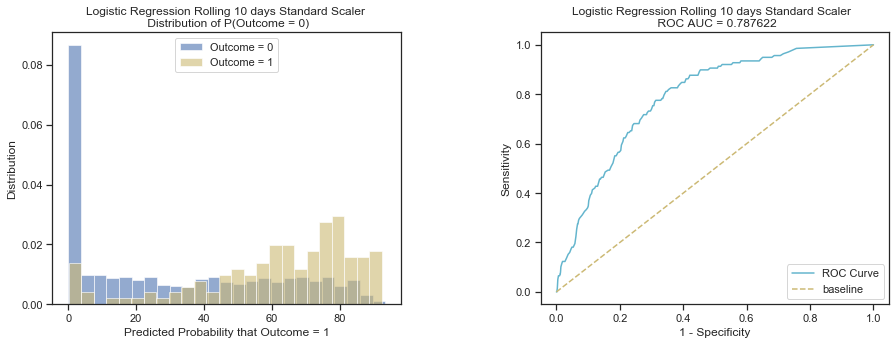

In [59]:
subplot_prob_dist(model_dict, ['lr_1'])

In [73]:
# plot feature importances
def plot_feat_imp(model_dict, model_classifier, model_number):
    model_name = '_'.join([model_classifier, str(model_number)])
    feat_imp = pd.DataFrame(model_dict[model_name]['model'].best_estimator_.steps[0][1].feature_importances_,
                            index = X_train[model_number].columns).sort_values(0 ,ascending=False).head(20)
    plt.figure(figsize = (10, 7))
    sns.barplot(x = feat_imp[0], y = feat_imp.index, color = 'skyblue')
    plt.title('Feature importance scores', fontsize=14)
    plt.xlabel('')
    plt.yticks(fontsize = 12)
    plt.tight_layout()

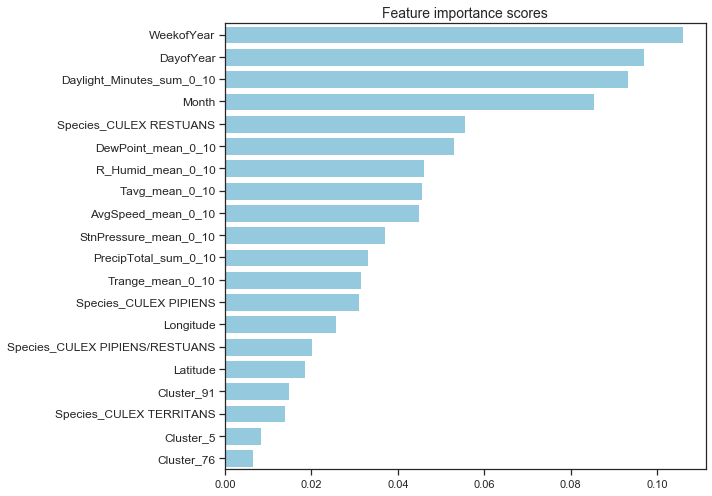

In [76]:
plot_feat_imp(model_dict, 'et', 1)

# Cost-Benefit Analysis

## Cost
The Chicago Department of Public Health (CDPH) conducts mosquito spraying as part of their measure to reduce the occurrence of WNV. The spraying is conducted from dusk to around midnight from ultra low volumn (ULV) sprayer trucks, using the chemical Zenivex™ E4 ([City of Chicago, 2019](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2019/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes.html)). This is a 4% solution of etofenprox, sprayed at 4.5 - 9 ounces per minute, at a vehicle speed of 10 - 15 mph ([Central Massachussettes Mosquito Control Project](https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox)). Assuming each truck has an area of effect of about 3 m to each side of the truck, the overall spray area is approximately **0.6 km<sup>2</sup>** per truck.

The cost of Zenivex E4 is about \$80 USD per gallon ([North Dakota Department of Health, 2013](http://www.gfmosquito.com/wp-content/uploads/2013/06/2013-North-Dakota-Bid-Tabulation.pdf)). Given the current rate of spraying and assuming a total spray duration of 5 hours, the cost of pesticides for <i>each sprayer truck</i> is <b>\\$843.76 - \$1687.50 USD</b>. 

Given that the total area of Chicago is 606.1 km<sup>2</sup>, it would take about 1000 trucks at the same time to cover the entire area. 

## Benefit
Benefits from mosquito spraying would include increased quality of life from fewer people falling sick and dying, increased workplace productivity from fewer people falling ill and going on medical leave, as well as savings in hospital expenses from treating WNV patients. Of these, only the latter two are measurable.

About 1 in 5 people infected with WNV develop West Nile fever with other symptoms such as headache, body aches, joint pains, vomiting, etc. Recovery from West Nile fever takes from a few days to several weeks, and prolonged fatigue is common ([Peterson, 2019](https://www.uptodate.com/contents/west-nile-virus-infection-beyond-the-basics)). 

About 1 in 150 people infected develop severe neuroinvasive diseases such as encephalitis or meningitis, in which the virus travels through the blood and infects the brain and spinal cord. Recovery is prolonged and less than 40% of patients with the severe diseases recover after one year ([Peterson, 2019](https://www.uptodate.com/contents/west-nile-virus-infection-beyond-the-basics)).

Given that the median household income in Chicago was \\$55,295 (as of 2017; [Data USA](https://datausa.io/profile/geo/chicago-il/)), one can estimate the amount of losses the city will face from an incapacitated workforce. In 2017, there were 90 WNV cases, including 8 deaths ([CBS Chicago, 2019](https://chicago.cbslocal.com/2018/08/29/west-nile-virus-death-reported-in-illinois/)). This means that approximately 18 people developed West Nile fever. Assuming all were working adults and each took two weeks off work to recover, this would have resulted in a total income loss of \\$19,353. On average, each WNV patient spends approximately \\$25,000 in the hospital. Therefore the total monetary loss caused by WNV in 2017 is approximately \\$488,176.

## Effectiveness of spraying efforts thus far
Based on the exploratory data analysis conducted earlier, there was a lack of evidence to support the claim that mosquito spraying had any effect on reducing the number of mosquitos. It was also revealed during earlier EDA that spraying was only done in 2011 and 2013, and mostly in September. As this is near the end of summer, breeding conditions were already becoming less favourable for mosquitos, therefore it would be difficult to discern the effects of spraying from the natural decline in mosquito populations. Further examinations of spraying efforts in 2013 August also did not reveal any noticable decrease in WNV occurrences. 

## Conclusions
From the graph below, it can be seen that the money saved from reducing WNV cases would at most fund about 300 - 500 sprays. However, as the current datasets do not substantially point to a significant impact from spraying, more evidence (from a better designed spraying regime) are needed for a more concrete recommendation. For example, spraying efforts could be concentrated at the beginning of August so that there would be enough time to observe if mosquito numbers decline, in the relative absence of other confounding factors (such as temperature). 

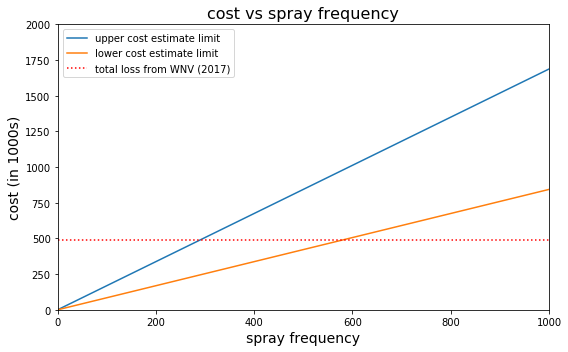

In [19]:
# max/optimal level of pesticide coverage
# spraying frequency of twice a month (to cover the mosquito life cycle)
# 1000 trucks at a time (to cover the whole Chicago)
max_frequency = 25 * 1000

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, max_frequency),
         np.arange(1, max_frequency) * 1687.5/1000, label = 'upper cost estimate limit')
plt.plot(np.arange(1, max_frequency),
         np.arange(1, max_frequency) * 843.75/1000, label = 'lower cost estimate limit')
plt.axhline(488_176/1000, color='r', linestyle=':', label = 'total loss from WNV (2017)')
plt.title('cost vs spray frequency', fontsize=16)
plt.xlabel('spray frequency', fontsize=14)
plt.ylabel('cost (in 1000s)', fontsize=14)
plt.ylim(0,2000)
plt.xlim(0,1000)
plt.legend()
plt.tight_layout()
plt.savefig('cost_benefit')

# Conclusion and Recommendations

Using XGBoost (our best performing model), we achieved an ROC_AUC of **0.834** and the following confusion matrix:

||predicted WNV absent|predicted WNV present|
|---|---|---|
|actual WNV absent|2031|458|
|actual WNV present|50|88|

Using the model, we found that WNV is more prevalent under certain conditions. **Week of year** was the top predictor by far for our model, followed by day of year, 18-days rolling sum of daylight hours, <i>Culex restuans</i>, and 18-days rolling mean of average temperature. This means that WNV is most likely to occur during certain weeks of the year (in August, as shown in the figure above), and therefore spray efforts should be concentrated during this period. Location was not a strong predictor in our model, suggesting that WNV clusters may be transient, occurring where best conditions emerge. 

After conducting a cost-benefit analysis, we found that the money saved from reducing WNV cases would at most fund about 300 - 500 sprays. However, as the current datasets do not substantially point to a significant impact from spraying, more evidence (from a better designed spraying regime) are needed for a more concrete recommendation. For example, spraying efforts could be concentrated at the beginning of August so that there would be enough time to observe if mosquito numbers decline, in the relative absence of other confounding factors (such as temperature). 